### 1. Data collection

In [8]:
from stackapi import StackAPI, StackAPIError
import time, pandas as pd
from tqdm import tqdm

KEY          = "rl_wda2vQgN7VXbq8jmT326Mw6t9"
OUTPUT_CSV   = "nlp_so_20k.csv"
TARGET_COUNT = 20000
PAGE_SIZE    = 100

SITE = StackAPI("stackoverflow", key=KEY)
SITE.page_size = PAGE_SIZE

questions, page = [], 1
while len(questions) < TARGET_COUNT:
    try:
        resp = SITE.fetch(
            "questions",
            tagged="nlp",
            filter="withbody",
            page=page,
            sort="creation",
            order="asc"
        )
    except StackAPIError as e:
        if e.code == "throttle_violation":
            time.sleep(60)
            continue
        raise
    if "backoff" in resp:
        time.sleep(resp["backoff"])
    items = resp.get("items", [])
    if not items:
        break
    for q in items:
        if "accepted_answer_id" in q:
            questions.append({
                "question_id":        q["question_id"],
                "title":              q["title"],
                "description":        q["body"],
                "tags":               ";".join(q["tags"]),
                "creation_date":      q["creation_date"],
                "view_count":         q["view_count"],
                "accepted_answer_id": q["accepted_answer_id"]
            })
    print(f"Page {page}: {len(questions)} / {TARGET_COUNT}")
    page += 1
    time.sleep(1)

questions = questions[:TARGET_COUNT]
df_q = pd.DataFrame(questions)

answers = []
for start in tqdm(range(0, len(df_q), PAGE_SIZE), desc="Answers"):
    ids = df_q["accepted_answer_id"][start:start+PAGE_SIZE].tolist()
    resp = SITE.fetch("answers", ids=ids, filter="withbody")
    if "backoff" in resp:
        time.sleep(resp["backoff"])
    for a in resp["items"]:
        answers.append({
            "accepted_answer_id": a["answer_id"],
            "accepted_answer":    a["body"]
        })
    time.sleep(1)

df_a = pd.DataFrame(answers)
df   = df_q.merge(df_a, on="accepted_answer_id", how="left")

# convert UNIX timestamp → human datetime
df['creation_date'] = pd.to_datetime(df['creation_date'], unit='s')

df.to_csv(OUTPUT_CSV, index=False, encoding="utf-8")
print(f"Saved {len(df)} rows to {OUTPUT_CSV}")


Page 1: 72 / 20000
Page 2: 202 / 20000
Page 3: 260 / 20000
Page 4: 327 / 20000
Page 5: 656 / 20000
Page 6: 968 / 20000
Page 7: 1210 / 20000
Page 8: 1396 / 20000
Page 9: 1516 / 20000
Page 10: 1575 / 20000
Page 11: 1698 / 20000
Page 12: 1764 / 20000
Page 13: 1830 / 20000
Page 14: 2057 / 20000
Page 15: 2217 / 20000
Page 16: 2320 / 20000
Page 17: 2369 / 20000
Page 18: 2485 / 20000
Page 19: 2540 / 20000
Page 20: 2595 / 20000
Page 21: 2638 / 20000
Page 22: 2684 / 20000
Page 23: 2831 / 20000
Page 24: 2930 / 20000
Page 25: 2983 / 20000
Page 26: 3024 / 20000
Page 27: 3117 / 20000
Page 28: 3168 / 20000
Page 29: 3212 / 20000
Page 30: 3258 / 20000
Page 31: 3305 / 20000
Page 32: 3440 / 20000
Page 33: 3535 / 20000
Page 34: 3584 / 20000
Page 35: 3625 / 20000
Page 36: 3669 / 20000
Page 37: 3718 / 20000
Page 38: 3760 / 20000
Page 39: 3812 / 20000
Page 40: 3988 / 20000
Page 41: 4109 / 20000
Page 42: 4188 / 20000
Page 43: 4228 / 20000
Page 44: 4275 / 20000
Page 45: 4455 / 20000
Page 46: 4585 / 20000
Page

Answers: 100%|██████████| 200/200 [04:38<00:00,  1.39s/it]


Saved 76377 rows to nlp_so_20k.csv


C:\Users\Administrator\AppData\Local\Temp\ipykernel_23220\391812860.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = df.set_index('creation_date').resample('M').size()


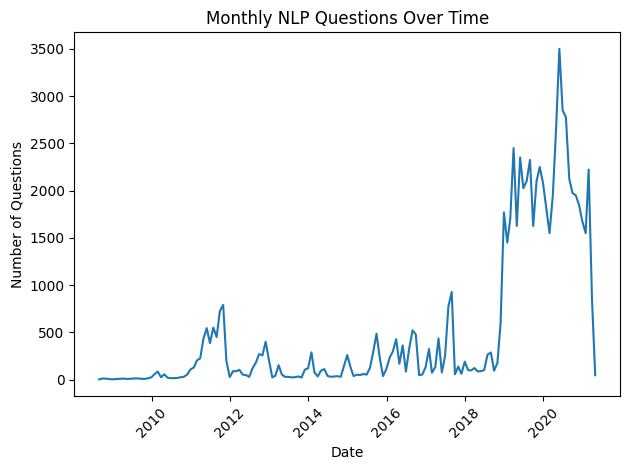

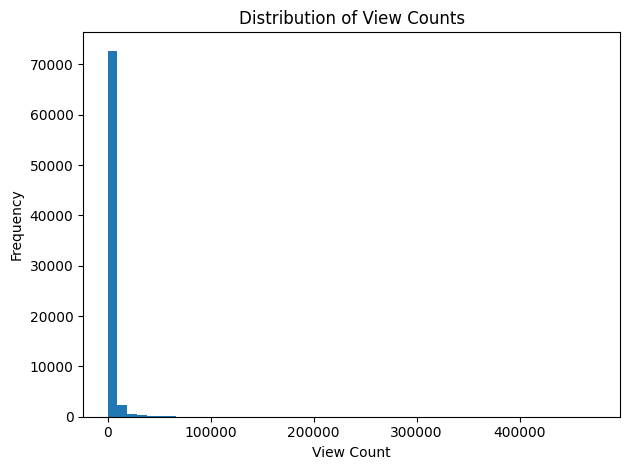

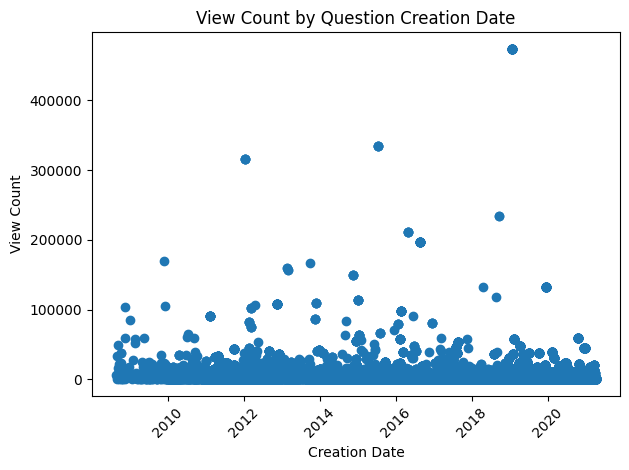

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv('nlp_so_20k.csv')

# Ensure creation_date is datetime
df['creation_date'] = pd.to_datetime(df['creation_date'])

# Chart 1: Number of NLP questions over time (monthly count)
monthly_counts = df.set_index('creation_date').resample('M').size()

plt.figure()
plt.plot(monthly_counts.index, monthly_counts.values)
plt.title('Monthly NLP Questions Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Chart 2: Distribution of view counts (histogram)
plt.figure()
plt.hist(df['view_count'], bins=50)
plt.title('Distribution of View Counts')
plt.xlabel('View Count')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Chart 3: Scatter plot of view count vs. creation date
plt.figure()
plt.scatter(df['creation_date'], df['view_count'])
plt.title('View Count by Question Creation Date')
plt.xlabel('Creation Date')
plt.ylabel('View Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 2. Pre-processing

In [19]:
import pandas as pd
import re

# Load the original dataset
df = pd.read_csv('nlp_so_20k.csv')

# Define cleaning function
def clean_text(text: str) -> str:
    text = str(text)
    # remove code blocks and image tags
    text = re.sub(r'<code>.*?</code>', ' ', text, flags=re.S)
    text = re.sub(r'<img[^>]*>', ' ', text)
    # strip HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # lowercase
    text = text.lower()
    # remove URLs
    text = re.sub(r'http\S+', ' ', text)
    # remove non-alphanumeric characters
    text = re.sub(r'[^a-z0-9\s;]', ' ', text)
    # collapse whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to each text column
text_columns = ['title', 'description', 'accepted_answer', 'tags']
for col in text_columns:
    clean_col = f"{col}_clean"
    df[clean_col] = df[col].apply(clean_text)

# Tokenize the cleaned text into lists of words
df['title_tokens']           = df['title_clean'].str.split()
df['description_tokens']     = df['description_clean'].str.split()
df['accepted_answer_tokens'] = df['accepted_answer_clean'].str.split()
df['tags_tokens']            = df['tags_clean'].str.split(';')

# Save the fully preprocessed dataset
output_file = 'nlp_so_20k_preprocessed.csv'
df.to_csv(output_file, index=False, encoding='utf-8')
print(f"Preprocessed dataset with tokens saved to {output_file}, shape: {df.shape}")



Preprocessed dataset with tokens saved to nlp_so_20k_preprocessed.csv, shape: (76377, 16)


### 3. Graphical representation of the dataset

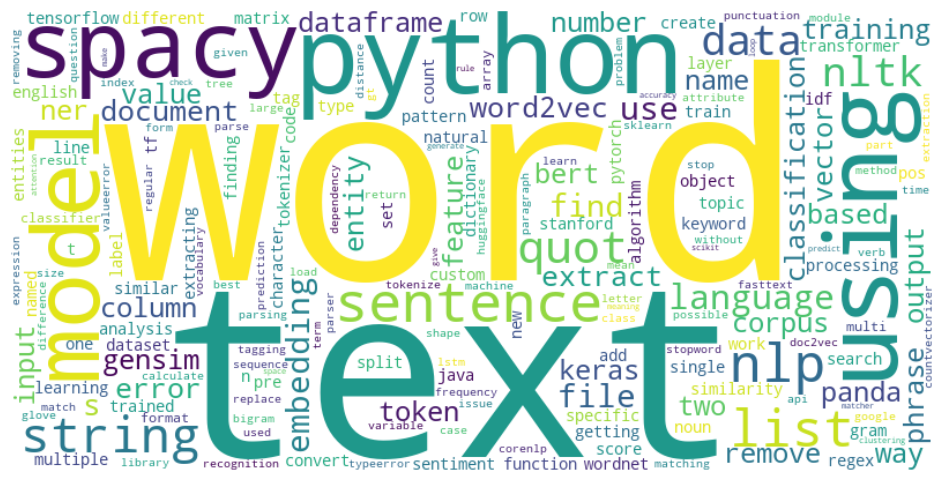

In [71]:
from wordcloud import WordCloud, STOPWORDS

# Load original dataset
df = pd.read_csv('nlp_so_20k.csv')

# Define cleaning for title only
def clean_text(html: str) -> str:
    text = re.sub(r'<code>.*?</code>', ' ', str(html), flags=re.S)
    text = re.sub(r'<img[^>]*>', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Clean titles
titles_clean = df['title'].apply(clean_text)

# Generate word cloud from cleaned titles
text = " ".join(titles_clean.tolist())
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=STOPWORDS,
    collocations=False
).generate(text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


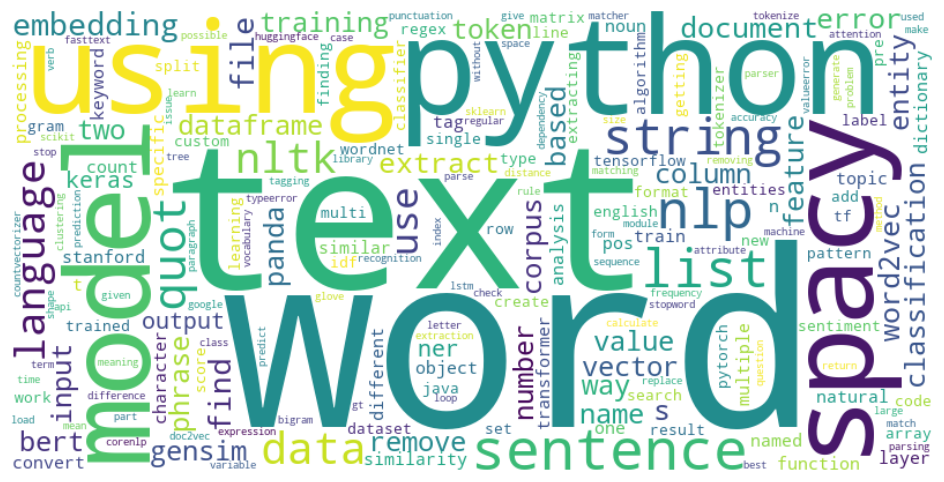

In [66]:
# Load preprocessed dataset
df = pd.read_csv('nlp_so_20k_preprocessed.csv')

# Clean titles
titles_clean = df['title'].apply(clean_text)

# Generate word cloud from cleaned titles
text = " ".join(titles_clean.tolist())
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=STOPWORDS,
    collocations=False
).generate(text)

# Plot
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()


### 4. Categorisation of the posts

In [74]:
import pandas as pd
import re

# Load raw dataset
df = pd.read_csv('nlp_so_20k.csv')

# Cleaning function for title
def clean_text(html: str) -> str:
    text = re.sub(r'<code>.*?</code>', ' ', str(html), flags=re.S)
    text = re.sub(r'<img[^>]*>', ' ', text)
    text = re.sub(r'<.*?>', ' ', text)
    text = text.lower()
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Create cleaned title
df['title_clean'] = df['title'].apply(clean_text)

# Categorization rules
def categorize(title: str) -> str:
    t = title.lower()
    if any(phr in t for phr in ['how to', 'how do i', 'config', 'setup', 'install']):
        return 'Implementation'
    if any(kw in t for kw in ['similarity', 'tokenization', 'classification', 'stemming', 'lemmatization', 'language', 'parsing', 'embedding']):
        return 'Task-based'
    if t.startswith(('what', 'why', 'explain')):
        return 'Conceptual'
    if any(lib in t for lib in ['spacy', 'nltk', 'transformers', 'gensim', 'word2vec', 'fasttext', 'lda']):
        return 'Library-specific'
    return 'Other'

df['category'] = df['title_clean'].apply(categorize)

# Summarize
counts = df['category'].value_counts().rename_axis('Category').reset_index(name='Count')
print("Category Counts:")
print(counts.to_string(index=False))

print("\nCategory Examples:")
for cat in counts['Category']:
    print(f"\n{cat}:")
    for title in df[df['category']==cat]['title_clean'].head(5):
        print(" -", title)


Category Counts:
Category          Count
           Other 38570 
  Implementation 16392 
Library-specific  9999 
      Task-based  8314 
      Conceptual  3102 

Category Examples:

Other:
 - how do you implement a quot did you mean quot
 - nlp qualitatively quot positive quot vs quot negative quot sentence
 - a stringtoken parser which gives google search style quot did you mean quot suggestions
 - methods for geotagging or geolabelling text content
 - theory quot lexical encoding quot

Implementation:
 - how to implement a quot related quot degree measure algorithm
 - how to read values from numbers written as words
 - how do i determine if a random string sounds like english
 - how to ensure user submit only english text
 - how to get started on information extraction

Library-specific:
 - using the python nltk 2 0b5 on the google app engine
 - should i use lingpipe or nltk for extracting names and places
 - sentiment analysis with nltk python for sentences using sample data or webs

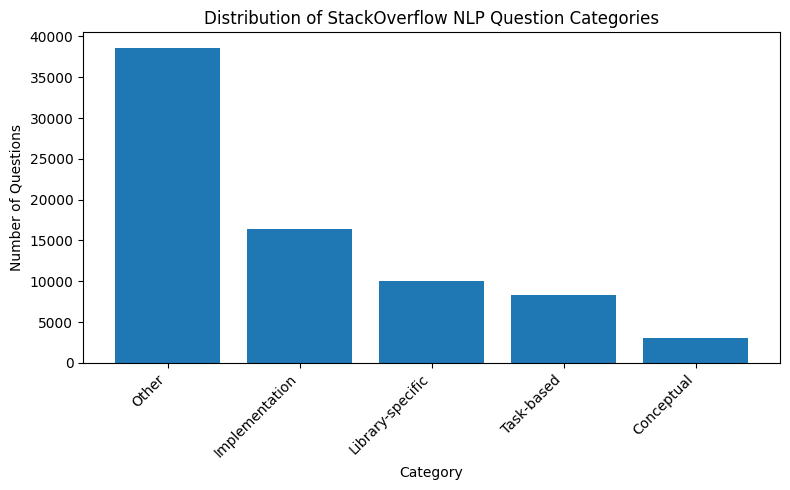

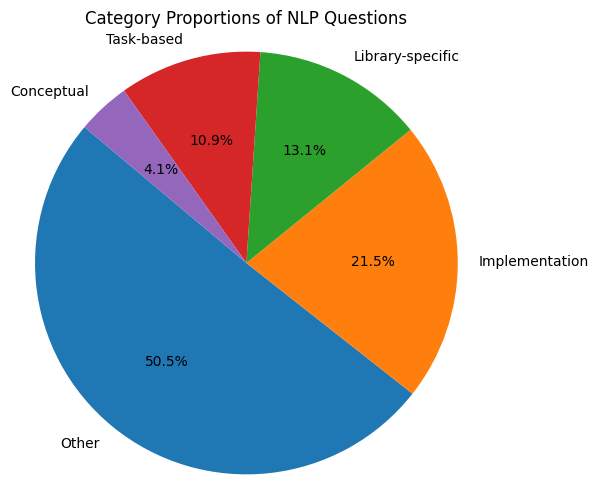

C:\Users\Administrator\AppData\Local\Temp\ipykernel_10844\4235362323.py:56: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')


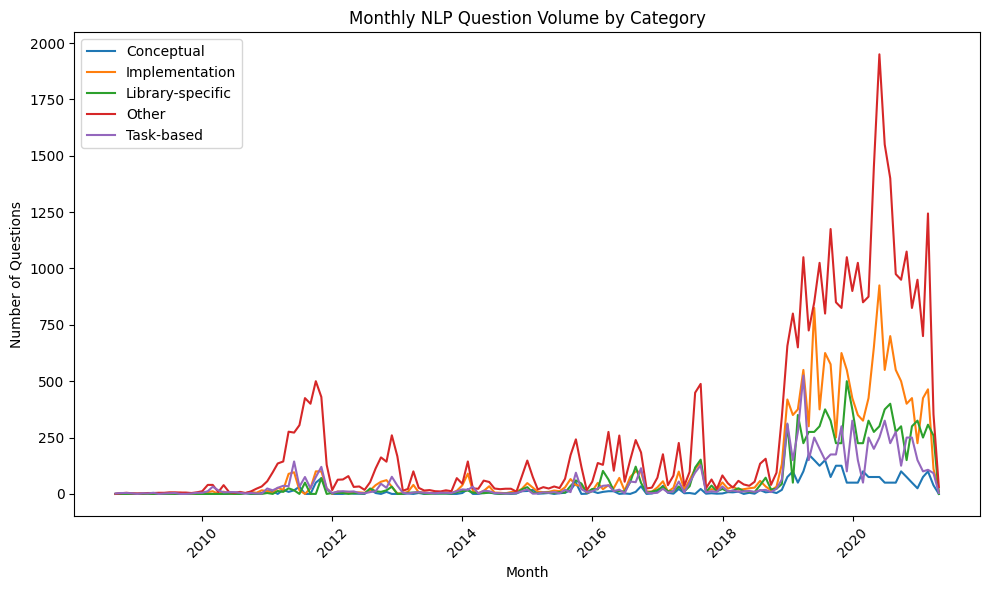

Average view count: 2545.4
Questions without an accepted answer: 449

Sample question URLs per category:
        category  level_1                                 example_urls
      Conceptual    44807 https://stackoverflow.com/questions/59285376
      Conceptual    10252 https://stackoverflow.com/questions/32812342
      Conceptual    37607 https://stackoverflow.com/questions/58327894
  Implementation    13940 https://stackoverflow.com/questions/41729287
  Implementation    61978 https://stackoverflow.com/questions/63157909
  Implementation    48095 https://stackoverflow.com/questions/60698839
Library-specific    43107 https://stackoverflow.com/questions/59155770
Library-specific    59367 https://stackoverflow.com/questions/62268302
Library-specific    17955 https://stackoverflow.com/questions/51686456
           Other    52560 https://stackoverflow.com/questions/61480584
           Other     5338  https://stackoverflow.com/questions/8892566
           Other    23335 https://stackover

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your preprocessed CSV with the 'category' column
df = pd.read_csv('nlp_so_20k_preprocessed.csv')

def categorize(title: str) -> str:
    t = title.lower()
    if any(kw in t for kw in ['how to', 'how do i', 'config', 'setup', 'install']):
        return 'Implementation'
    if any(kw in t for kw in ['similarity', 'tokenization', 'classification',
                               'stemming', 'lemmatization', 'language',
                               'parsing', 'embedding']):
        return 'Task-based'
    if t.startswith(('what', 'why', 'explain')):
        return 'Conceptual'
    if any(lib in t for lib in ['spacy', 'nltk', 'transformers',
                                'gensim', 'word2vec', 'fasttext', 'lda']):
        return 'Library-specific'
    return 'Other'

df['category'] = df['title_clean'].apply(categorize)

# Count how many posts fall into each category
counts = df['category'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts.values)
plt.xticks(rotation=45, ha='right')
plt.title('Distribution of StackOverflow NLP Question Categories')
plt.xlabel('Category')
plt.ylabel('Number of Questions')
plt.tight_layout()
plt.show()

# Pie Chart of Category Proportions
plt.figure(figsize=(6,6))
plt.pie(counts.values,
        labels=counts.index,
        autopct='%1.1f%%',
        startangle=140)
plt.title('Category Proportions of NLP Questions')
plt.axis('equal')
plt.show()

# Monthly Time Series by Category

df['creation_date'] = pd.to_datetime(df['creation_date'])

# Pivot to get a DataFrame of monthly counts per category
monthly = (
    df
    .set_index('creation_date')
    .groupby('category')
    .resample('M')
    .size()
    .unstack('category')
    .fillna(0)
)

plt.figure(figsize=(10,6))
for cat in monthly.columns:
    plt.plot(monthly.index, monthly[cat], label=cat)
plt.legend(loc='upper left')
plt.title('Monthly NLP Question Volume by Category')
plt.xlabel('Month')
plt.ylabel('Number of Questions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Compute average views & unanswered counts
avg_views = df['view_count'].mean()
no_answer_count = df['accepted_answer_clean'].isna().sum()
print(f"Average view count: {avg_views:.1f}")
print(f"Questions without an accepted answer: {no_answer_count}")

# Sample URLs per category
def make_so_url(qid): return f"https://stackoverflow.com/questions/{qid}"
sample_urls = (
    df.groupby('category')['question_id']
      .apply(lambda ids: ids.sample(3, random_state=42).map(make_so_url))
      .reset_index(name='example_urls')
)
print("\nSample question URLs per category:")
print(sample_urls.to_string(index=False))



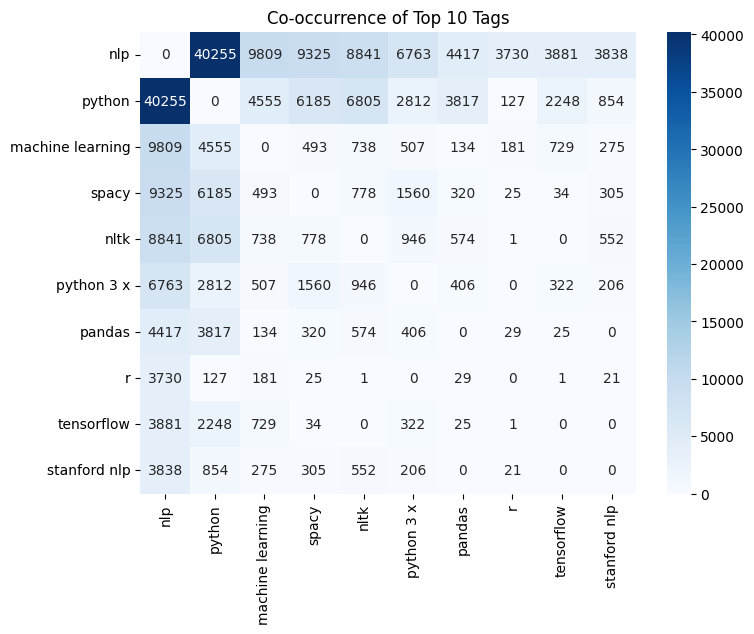

In [13]:
# Build a co-occurrence matrix for top-10 tags
tags = df['tags_clean'].str.split(';')
all_tags = pd.Series([t for sub in tags for t in sub])
top10 = all_tags.value_counts().head(10).index
matrix = pd.DataFrame(0, index=top10, columns=top10)

for row in tags:
    row_tags = [t for t in row if t in top10]
    for i in row_tags:
        for j in row_tags:
            if i != j:
                matrix.loc[i, j] += 1

plt.figure(figsize=(8,6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues")
plt.title('Co‑occurrence of Top 10 Tags')
plt.show()
